## 0)import libraries 

In [1]:
import os
import pickle

import dask.array as da
import numpy as np
import pandas as pd
import xarray as xr

from PyStemmusScope import variable_conversion as vc
from sklearn.preprocessing import OneHotEncoder
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

## 1)settings for Dask

In [2]:
# Set the MALLOC_TRIM_THRESHOLD_ environment variable
os.environ['MALLOC_TRIM_THRESHOLD_'] = '0'

In [3]:
# cluster = LocalCluster(n_workers=4, threads_per_worker=1)

Setup a Dask cluster on 6 * 16 = 96 cores (6 * 4 = 24 workers with 4 threads each) and 6 * 120 GB = 720 GB memory in total ('fat' nodes on Snellius):

In [4]:
cluster = SLURMCluster(
    name='dask-worker',
    cores=16,
    processes=4,
    queue='fat',
    memory='120GiB',
    local_directory='$TMPDIR',
    walltime='1:00:00'
)
cluster.scale(jobs=4)

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38403 instead
  warnings.warn(


In [5]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/38403/status,
Dashboard: /proxy/38403/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://145.136.63.1:44229,Workers: 0
Dashboard: /proxy/38403/status,Total threads: 0
Started: Just now,Total memory: 0 B


## 2)define working path, load trained model, define functions

In [4]:
year = 2014

In [5]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
DATA_DIR = f'{ROOT_DIR}/qianqian/global_data_Qianqian/1input_data/{year}global'
ERA5_PATH = f'{DATA_DIR}/era5land/era5land.zarr'
LAI_PATH = f'{DATA_DIR}/lai/lai.zarr'
SSM_PATH = f'{DATA_DIR}/ssm/ssm.zarr'
CO2_PATH = f'{DATA_DIR}/co2/co2.zarr'
LANDCOVER_PATH = f'{DATA_DIR}/igbp/landcover.zarr'
IGBP_CLASS_PATH = f'{ROOT_DIR}/qianqian/global_data_Qianqian/1input_data/IGBP11unique.csv'
IGBP_TABLE_PATH = f'{ROOT_DIR}/qianqian/global_data_Qianqian/1input_data/{year}global/igbp/lccs_to_igbp_table.csv' 
hc_PATH = f'{DATA_DIR}/canopy_height/hc.zarr'
VCMAX_PATH = f'{DATA_DIR}/vcmax/vcmax.zarr'
MODEL_PATH = f'{ROOT_DIR}/qianqian/global_data_Qianqian/3RF_train/hourly_multi7_depth20_min1219.pkl'

LEH_PATH = f'{ROOT_DIR}/qianqian/global_data_Qianqian/5output_data/{year}fluxes_test_linear_nearest.zarr'

In [6]:
# function for loading the trained model
def load_model(path):
    # load trained RF model, better use not parallel model with Dask
    with open(path, 'rb') as f:
        rfLEHmulti = pickle.load(f)
    return rfLEHmulti

## 3) read data

In [7]:
## 0) read era5land data
era5 = xr.open_zarr(ERA5_PATH)
# round coordinates to facilitate matching with other datasets
era5 = era5.assign_coords(
    longitude=era5.longitude.round(4),
    latitude=era5.latitude.round(4)
)

In [8]:
# 120 x 120 degrees
era5 = era5.sel(
    latitude=slice(81.85192337, 34.93055094),  # (0., 125.) deg
    longitude=slice(0, 68.93136141),  # (90., -35.) deg
)
# era5 = era5.sel(
#     latitude=slice(45, 40),  # (0., 125.) deg
#     longitude=slice(2, 7),  # (90., -35.) deg
# )

Conversion to half-hourly quantities involves:

1. resampling to half-hourly grid;
2. differentiation with respect to time;

The order in which these tasks are carried matters: one should first resample the cumulative quantities to a finer grid and only then do the differentiation with respect to time. I think these tasks were carried out in the wrong order in an earlier version of the notebook.

In addition, the resampling to a half-hourly grid is problematic since it creates a single time chunk, increasing enormously the memory footprint of the calculation. Could we calculate half-hourly quantities (as I understood, these are required by the model) but on an hourly grid instead? As far as I understand, dividing by two `Rin` and `Rli` should bring them to half-hour-based unit. If results are required on a half-hourly grid, one could always interpolate results..   

In [9]:
# calculate the Rin and Rli difference for every hour
ssrd = era5['ssrd'] / 3600
Rin = ssrd.diff("time")
Rin[0::24] = ssrd[1::24]

strd = era5['strd'] / 3600
Rli = strd.diff("time")
Rli[0::24] = strd[1::24]

In [10]:
Precip_msr = era5['tp'].diff("time")  #xr.concat([all1['ssrd'].isel(time=0),all1['ssrd']], dim="time")
Precip_msr[0::24] = era5['tp'][1::24] # assign the original values in t01

In [11]:
p = era5["sp"]/100  # Pa -> hPa
Ta = era5["t2m"] - 273.15  # K -> degC
ea = vc.calculate_es(era5["d2m"] - 273.15)*10 #kPa -> hPa
u = (era5["u10"] ** 2 + era5["v10"] ** 2) ** 0.5
Precip_msr = Precip_msr*1000 # mm

In [12]:
### 1) read LAI data
LAI = xr.open_zarr(LAI_PATH).sel(time=str(year))
LAI = LAI.assign_coords(
    longitude=LAI.longitude.round(4),
    latitude=LAI.latitude.round(4)
)

In [13]:
LAI = LAI['LAI']

In [14]:
LAI = LAI.sel(
    latitude=slice(81.85192337, 34.93055094),  # (0., 125.) deg
    longitude=slice(0, 68.93136141),  # (90., -35.) deg
)

Interpolation creates a single chunk in time! Can we use nearest-neighbour to match the time domain of the ERA5 dataset instead?

In [260]:
# # # INTERPOLATION CREATES A SINGLE CHUNK IN TIME!
LAI = LAI.resample(time='1D').interpolate('linear')

The following Dask option allows to avoid creating a single time chunk when using nearest-neighbour matching: 

In [262]:
import dask.config

with dask.config.set({"array.slicing.split_large_chunks": True}):
    LAI = LAI.resample(time='1H').nearest()

In [216]:
### 2) read SSM data
SSM = xr.open_zarr(SSM_PATH)
SSM = SSM.assign_coords(
    longitude=SSM.longitude.round(4),
    latitude=SSM.latitude.round(4)
)
SSM = SSM.sel(
    latitude=slice(81.85192337, 34.93055094),  # (0., 125.) deg
    longitude=slice(0, 68.93136141),  # (90., -35.) deg
)

In [217]:
SSM = SSM['SSM']

In [218]:
# # INTERPOLATION CREATES A SINGLE CHUNK IN TIME!
SSM = SSM.resample(time='1H').interpolate('linear')/1000 

In [224]:
### 3) read CO2 data
CO2 = xr.open_zarr(CO2_PATH)
CO2 = CO2.assign_coords(
    longitude=CO2.longitude.round(4),
    latitude=CO2.latitude.round(4)
)
CO2 = CO2['co2']
CO2 = CO2.sel(
    latitude=slice(81.85192337, 34.93055094),  # (0., 125.) deg
    longitude=slice(0, 68.93136141),  # (90., -35.) deg
)

In [225]:
# # # # INTERPOLATION CREATES A SINGLE CHUNK IN TIME!
# CO2 = CO2.resample(time='1H').interpolate('linear')

In [226]:
with dask.config.set({"array.slicing.split_large_chunks": True}):
    CO2 = CO2.resample(time='1H').nearest()

**Done datasets up to here!** Moving on with landcover

----

In [227]:
## 4) read IGBP data
hc = xr.open_zarr(hc_PATH)
hc = hc.assign_coords(
    longitude=hc.longitude.round(4),
    latitude=hc.latitude.round(4)
)

In [228]:
hc = hc['hc']

In [229]:
hc = hc.sel(
    latitude=slice(81.85192337, 34.93055094),  # (0., 125.) deg
    longitude=slice(0, 68.93136141),  # (90., -35.) deg
)

In [230]:
## 5) read Vcmax data
vcmax = xr.open_zarr(VCMAX_PATH)
vcmax = vcmax.assign_coords(
    longitude=vcmax.longitude.round(4),
    latitude=vcmax.latitude.round(4)
)

In [231]:
vcmax = vcmax['vcmax']

In [232]:
vcmax = vcmax.sel(
    latitude=slice(81.85192337, 34.93055094),  # (0., 125.) deg
    longitude=slice(0, 68.93136141),  # (90., -35.) deg
)

In [233]:
vcmax

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray 'vcmax' (latitude: 469, longitude: 690)>
dask.array<getitem, shape=(469, 690), dtype=float32, chunksize=(250, 250), chunktype=numpy.ndarray>
Coordinates:
    band       int64 1
  * latitude   (latitude) float32 81.8 81.7 81.6 81.5 ... 35.3 35.2 35.1 35.0
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 0.4 ... 68.6 68.7 68.8 68.9
Attributes:
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref
    offsets:        0.0
    scales:         1.0

---

In [234]:
## 6) read IGBP data
landcover = xr.open_zarr(LANDCOVER_PATH)
landcover = landcover.assign_coords(
    longitude=landcover.longitude.round(4),
    latitude=landcover.latitude.round(4)
)

In [235]:
landcover = landcover['lccs_class']

In [236]:
landcover = landcover.sel(
    latitude=slice(81.85192337, 34.93055094),  # (0., 125.) deg
    longitude=slice(0, 68.93136141),  # (90., -35.) deg
)

In [237]:
# read IGBP unique values
training_testing_append = pd.read_csv(IGBP_CLASS_PATH)['0'].unique()
# read the table for converting landcover to IGBP
IGBP_table = pd.read_csv(IGBP_TABLE_PATH)

In [238]:
def landcover_to_igbp(landcover, IGBP_table, training_testing_append):
    get_IGBP = np.vectorize(IGBP_table.set_index("lccs_class").T.to_dict('records')[0].get)
    IGBP = get_IGBP(landcover.values) 
    IGBP_all = pd.DataFrame(
        columns=[f'IGBP_veg_long{i}' for i in range(1, 12)]
    )
    
    # define one hot encoding for IGBP
    encoder = OneHotEncoder(
        categories=[training_testing_append],
        sparse=False,
        handle_unknown="ignore"
    )
    
    # transform data
    aa = encoder.fit_transform(IGBP.reshape(IGBP.shape[0]*IGBP.shape[1], 1))
    
    # assign 23-D IGBP into 23 columns
    for i in range(1, 12):
        IGBP_all[f'IGBP_veg_long{i}'] = aa[:,i-1]
    return IGBP_all

## 4) chunk all the input variables

**Missing data here!** I haven't loaded the CO2 and SSM datasets.

In [239]:
ds = xr.Dataset()

ds = ds.assign(
    Rin=Rin,
    Rli=Rli,
    p=p,
    Ta=Ta,
    ea=ea,
    u=u,
    Precip_msr=Precip_msr,
    LAI=LAI,
#######
    CO2=CO2,
    SSM=SSM,
#######
)

ds = ds.to_array()

ds = ds.chunk(time=125, variable=-1)

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [240]:
ds

<xarray.DataArray (variable: 10, time: 8761, latitude: 469, longitude: 690)>
dask.array<rechunk-merge, shape=(10, 8761, 469, 690), dtype=float64, chunksize=(10, 125, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 81.8 81.7 81.6 81.5 ... 35.3 35.2 35.1 35.0
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 0.4 ... 68.6 68.7 68.8 68.9
  * time       (time) datetime64[ns] 2014-01-01 ... 2015-01-01
  * variable   (variable) object 'Rin' 'Rli' 'p' 'Ta' ... 'LAI' 'CO2' 'SSM'

## 5) predict fluxes with map_blocks

In [241]:
INPUT_VARIABLES = [
    'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2','LAI','Vcmo','hc', 'Precip_msr',  
    'SSM',  *[f'IGBP_veg_long{i}' for i in range(1, 12)]
]
OUTPUT_VARIABLES = ['LEtot','Htot','Rntot','Gtot', 'Actot','SIF685', 'SIF740']

In [242]:
chunks = [ds.chunksizes[v] for v in ['time', 'latitude', 'longitude']]
chunks.append((len(OUTPUT_VARIABLES),))

template_LEH = xr.DataArray(
    name = 'LEH',
    data=da.zeros(
        (len(ds.time), len(ds.latitude), len(ds.longitude), len(OUTPUT_VARIABLES)), 
        chunks=chunks,
    ),
    dims=("time", "latitude", "longitude", "output_variable"),
    coords={
        "output_variable": OUTPUT_VARIABLES, 
        "time": ds.time, 
        "latitude": ds.latitude,
        "longitude": ds.longitude
    }
)

**Fake data here!** instead of taking `ds['CO2']` and `ds['SSM']` , I use `ds['p']` and `ds['Ta']`: 

In [243]:
def expand_time_dimension(data, n_time):
    """ 
    Expand the space-dependent data over the time dimension.
    
    Parameters
    ----------
    data : np.ndarray
        (ny, nx) matrix
    n_time : int
        number of elements in the time dimension
    
    Returns
    -------
    np.ndarray
        (1, ntime*ny*nx) matrix
    """
    expanded = np.tile(data.reshape(1, -1), (n_time, 1))
    return expanded.reshape(1, -1)
    

def predictFlux(ds, hc, Vcmo, landcover, IGBP_table, training_testing_append, path_model):

    n_time = len(ds.time)
    
    hc_ = expand_time_dimension(hc.data, n_time)
    Vcmo_ = expand_time_dimension(Vcmo.data, n_time)
    
    IGBP_all = landcover_to_igbp(landcover, IGBP_table, training_testing_append)
    IGBP_ = [
        expand_time_dimension(IGBP_all[f'IGBP_veg_long{i}'].to_numpy(), n_time)
        for i in range(1, 12)
    ]
    
    Rin_ = ds.sel(variable='Rin').data.reshape(1, -1)
    Rli_ = ds.sel(variable='Rli').data.reshape(1, -1)
    p_ = ds.sel(variable='p').data.reshape(1, -1)
    Ta_ = ds.sel(variable='Ta').data.reshape(1, -1)
    ea_ = ds.sel(variable='ea').data.reshape(1, -1)
    u_ = ds.sel(variable='u').data.reshape(1, -1)
    Precip_msr_ = ds.sel(variable='Precip_msr').data.reshape(1, -1)
    LAI_ = ds.sel(variable='LAI').data.reshape(1, -1)
###############
#    CO2_ = ds.sel(variable='CO2').data.reshape(1, -1)
#    SSM_ = ds.sel(variable='SSM').data.reshape(1, -1)
    CO2_ = ds.sel(variable='CO2').data.reshape(1, -1)
    SSM_ = ds.sel(variable='SSM').data.reshape(1, -1)
###############

    features_arr = np.concatenate((
        Rin_, Rli_, p_, Ta_, ea_, u_,  CO2_,LAI_,Vcmo_,hc_,Precip_msr_,   SSM_,  *IGBP_
    ))
    features_arr = features_arr.transpose()
    df_features = pd.DataFrame(
        data=features_arr,
        columns=INPUT_VARIABLES,
    )
    invalid_index = df_features.isnull().any(axis=1)
    
    # Convert the nan value as 0 for the calculation
    df_features[invalid_index] = 0
    
    model = load_model(path_model)
    LEH = model.predict(df_features)
    LEH[invalid_index] = np.nan
    
    return xr.DataArray(
        name='LEH',
        data=LEH.reshape(len(ds.time), len(ds.latitude), len(ds.longitude), len(OUTPUT_VARIABLES)),
        dims=("time", "latitude", "longitude", "output_variable"),
        coords={
            "output_variable": OUTPUT_VARIABLES, 
            "time": ds.time, 
            "latitude": ds.latitude,
            "longitude":ds.longitude
        }
    )

**Fake data here!** instead of passing `hc, Vcmo, landcover`, I pass three times `landcover`: 

In [244]:
# hc = hc.chunk({"latitude":51})
# vcmax = vcmax.chunk({"latitude":51})
# landcover = landcover.chunk({"latitude":51})

In [245]:
LEH = xr.map_blocks(
    predictFlux,
    ds,
#########
    # args=[hc, Vcmo, landcover],
    args=[hc, vcmax, landcover],
#########
    kwargs={
        "IGBP_table": IGBP_table, 
        "training_testing_append": training_testing_append, 
        "path_model": MODEL_PATH,
    },
    template=template_LEH,
)

In [246]:
LEH = LEH.chunk({"latitude":200, "longitude":200})

In [247]:
LEH_ds = LEH.to_dataset(dim="output_variable") 

In [248]:
%%time
LEH_ds.to_zarr(LEH_PATH, mode='w')

CPU times: user 2min 50s, sys: 6.39 s, total: 2min 56s
Wall time: 9min 4s


Release resources of the Dask cluster:

In [ ]:
client.shutdown()

Verify the output is written:

In [255]:
! du -h $LEH_PATH

5.3G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_test_linear_nearest.zarr/Htot
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_test_linear_nearest.zarr/longitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_test_linear_nearest.zarr/latitude
5.4G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_test_linear_nearest.zarr/Gtot
3.6G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_test_linear_nearest.zarr/SIF685
2.5K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_test_linear_nearest.zarr/time
3.7G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_test_linear_nearest.zarr/Actot
5.3G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_test_linear_nearest.zarr/LEtot
5.2G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_test_line

In [251]:
LEH_linear_nearest = xr.open_zarr(LEH_PATH)

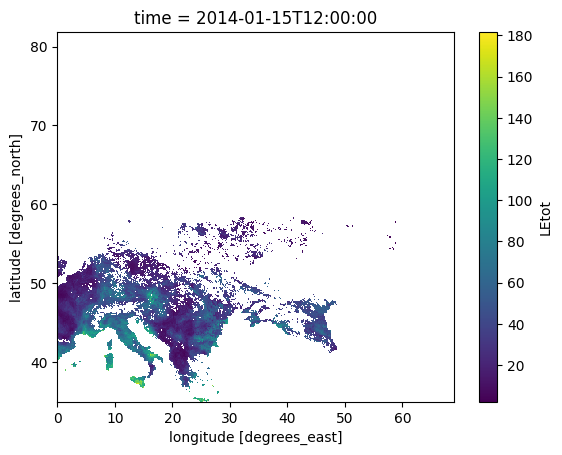

In [271]:
LEH_linear_nearest.LEtot[348,:].plot()

In [252]:
LEH_linear = xr.open_zarr('/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/2014fluxes_test_linear.zarr')

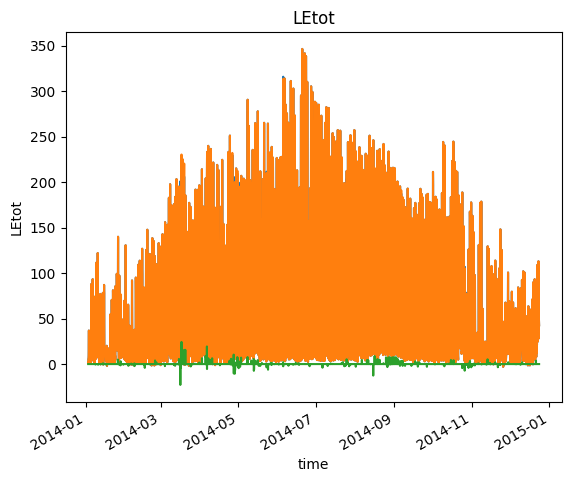

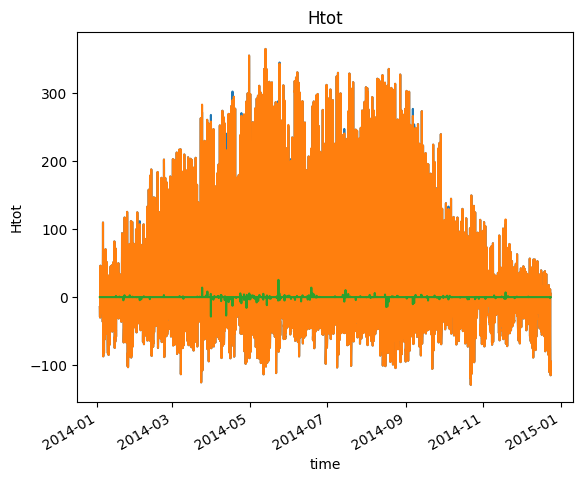

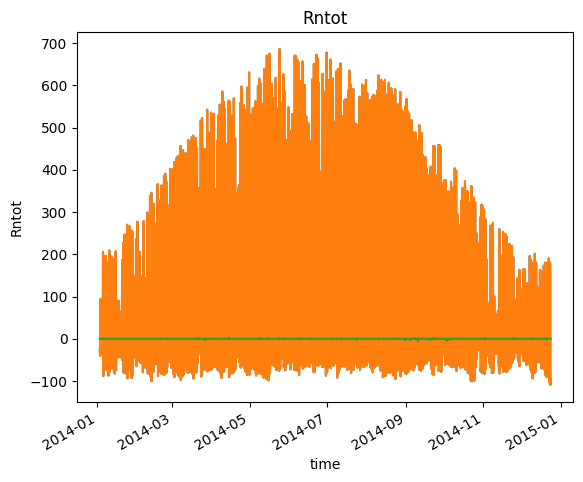

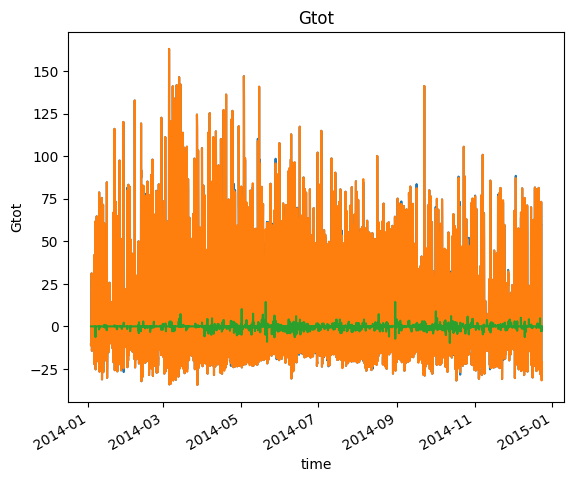

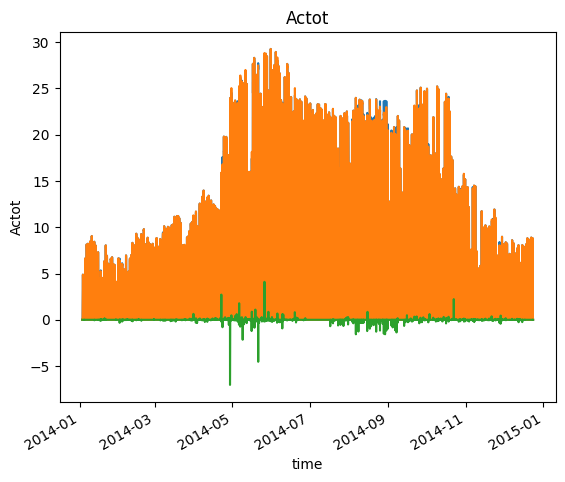

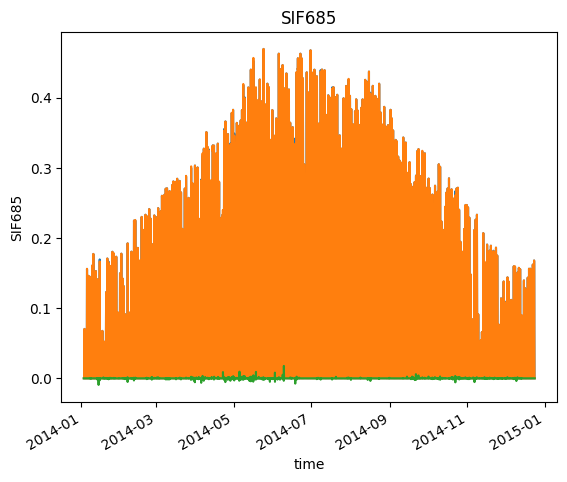

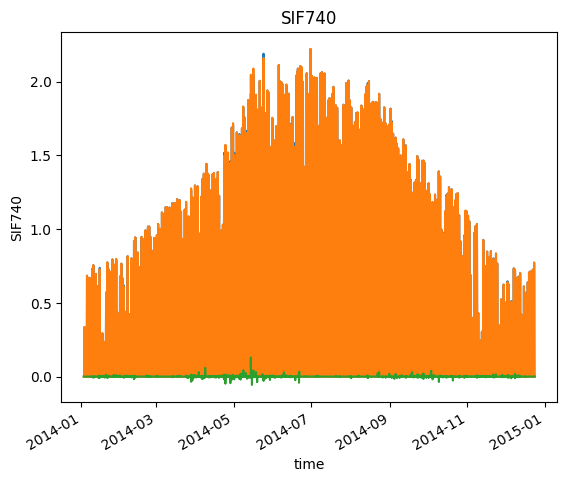

In [253]:
from matplotlib import pyplot as plt
for var in OUTPUT_VARIABLES:
    LEH_linear[var][:,10,45].plot()
    LEH_linear_nearest.sel(latitude=44,longitude=6.5)[var][:].plot()
    (LEH_linear_nearest.sel(latitude=44,longitude=6.5)[var][:] - LEH_linear[var][:,10,45]).plot()
    plt.title(var)
    plt.show()